<div class="alert alert-block alert-success">
<h1><b>PROJET 9 - </b>Réalisez une application de recommandation de contenu</h1>
<h2>Notebook Scripts</h2></div>

<img src="images/my_content.png" width="250" height="250">

## Table of Contents<hr>
[INTRODUCTION & PRESENTATION](#section_0)<br>
[A - IMPORTATIONS](#section_0A)<br>
[B - DATA COLLECTION & FIRST DATA DESCRIPTION](#section_0B)<br>
[C - EXPLORATORY DATA ANALYSIS](#section_0C)<br>
&emsp;[1 - Data Types](#section_0C1)<br>
&emsp;[2 - Summary](#section_0C2)<br>
&emsp;[3 - Vizualization and conclusions](#section_0C3)<br><hr>
[PART 1 - DATA PREPARATION](#section_1)<br>
[A - FINAL DATASET FOR CONTENT-BASED FILTERING](#section_1A)<br>
&emsp;[1 - Embedding](#section_1A1)<br>
&emsp;[2 - Final dataset](#section_1A2)<br>
[B - FINAL DATASET FOR COLLABORATIVE FILTERING](#section_1B)<br>
&emsp;[1 - Creating the Rating](#section_1B1)<br>
&emsp;[2 - Final dataset](#section_1B2)<br>
[C - PERFORMANCE AND DISTANCE METRICS](#section_1C)<br>
&emsp;[1 - Performance metrics](#section_1C1)<br>
&emsp;[2 - Distance metrics](#section_1C2)<br><hr>
[PART 2 - CONTENT-BASED METHODS](#section_2)<br>
[A - PRESENTATION OF THIS APPROACH](#section_2A)<br>
[B - DEFINING SIMILARITY](#section_2B)<br>
[C - RECOMMENDATION](#section_2C)<br><hr>
[PART 3 - COLLABORATIVE FILTERING METHODS](#section_3)<br>
[A - PRESENTATION OF THIS APPROACH](#section_3A)<br>
[B - DEFINING SIMILARITY](#section_3B)<br>
[C - RECOMMENDATION](#section_3C)<br><hr>
[CONCLUSION](#section_00)<br>

<h2><div class="alert alert-block alert-success" id="section_0">
INTRODUCTION & PRESENTATION</div></h2>

### Our mission

<b>My Content</b> is a start-up that wants to encourage reading by <b>recommending relevant content for its users</b>.<br><br>
The objective here is to <b>build a first MVP</b> which will take the form of an <b>application</b> which will initially <b>recommend five articles to the user</b>.

### Origin of the datasets

To perform the MVP, we will use <b>data available online</b>.<br>
This data <b>represents user interactions with available articles on the globo.com website</b> (a Brazilian free-to-air television network), between the 1st to 17th of October 2017.<br>
We have almost <b>3 million clicks in more than 1 million sessions from around 65 000 users who read more than 46 000 different news articles</b> during that period.<br><br>
We will use the files inside the unzipped <b>clicks.zip</b> folder, the <b>articles_metadata.csv</b> file and finally the <b>articles_embeddings.pickle</b> file.<br><br>
The clicks files contain user sessions interactions in the news portal, one per hour, so 385 in total during the period of time.<br>
The articles file contains information about all 364 047 published articles.<br>
The last file contains the article content embeddings (vectors of dimension 250), trained upon these articles's text and metadata.

### Software architecture

The software architecture must meet the business need and will be explained in detail in the slide presentation.<br>To implement this MVP, we will use the serverless services of the Azure portal.<br><br>
Broadly, the software architecture implemented consists of a client, the <b>Django web application</b>, an <b>Azure Functions</b> server and an <b>Azure Blob storage</b> database.<br><br>
The needs for <b>updating the Users and Articles</b> databases have been also taken into account.

### What is a recommender system? TODO

A recommendation system (or recommender system) is a AI algorithm that uses Big Data to suggest or recommend additional products to consumers. Data help predict, narrow down, and find what people are looking for among an exponentially growing number of options.

Recommendation systems exploit user preferences and traits to prioritize and recommend items which the users would like. It's used by large companies (like Amazon, Facebook, Google and Netflix) to drive significant customer engagement and revenue.<br>
In short, recommendation systems are systems that help users discover items they may like.

Recommendation systems are built to predict what users migth like, especially when there are lots o choices available, like here with the amoun of articles.

They can expose a user to content they may not have otherwise found or keep a user engaged for longer than they otherwise wouls have been.

As users continue to consume content and provide more data, these systems can be built to provide better and better recommendations. 

There are 2 common ways to implement a recommender system:<br>
    • Collaborative Filtering (CF)<br>
    • Content-Based Filtering (CBF)

The third way is an hybrid of the first two.

We will describe this further down in the notebook.

<img src="images/recommender_systems.png" width="500" height="500">

### Recommender System algorithms TODO

Concevoir des scripts permettant d’exécuter une chaîne de traitements IA bout-en-bout :<br>
• les scripts permettant d’entraîner et de tester le modèle de recommandation ont été développés et testés.<br>
• au moins un des algorithmes de chacune des deux approches (CF et content-based) de système de recommandation a été testé.<br>
• la fonction serverless renvoyant la prédiction du modèle intégrée à l’application mobile a été testée.

<h3><div class="alert alert-block alert-info" id="section_0A">
A - IMPORTATIONS</div></h3>

In [1]:
%matplotlib inline

# Importation of Python modules and methods.
import os
import pickle5 as pickle
import random
import warnings
from collections import defaultdict
from glob import glob

# Importation of Machine Learning libraries.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Importation of a Recommender System library.
from surprise import (
    accuracy,
    Dataset, 
    KNNWithMeans,
    KNNBaseline,
    Reader, 
    SVD
)
from surprise.model_selection import train_test_split, GridSearchCV

# warnings.filterwarnings("ignore")

<h3><div class="alert alert-block alert-info" id="section_0B">
B - DATA COLLECTION & FIRST DATA EXPLORATION</div></h3>

In [2]:
# Creation of pandas DataFrames with CSV files.

# Clicks DataFrame.
# Creating, if not existing yet, the clicks.csv file that is a concatenation of 
# the 385 clicks_hour_***.csv files. Then creating the df_clicks DataFrame out of it.
if not os.path.exists('clicks.csv'):
    clicks_path = sorted(
    glob(f'datasets/clicks/*.csv', recursive = True))
    clicks_hour_list = []
    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        clicks_hour_list.append(df)

    df_clicks = pd.concat(clicks_hour_list, axis=0, ignore_index=True)
    df_clicks.to_csv('datasets/clicks.csv')
else:
    df_clicks = pd.read_csv('datasets/clicks.csv')

# Articles DataFrame.
df_articles = pd.read_csv(
    'datasets/articles_metadata.csv', sep=',', low_memory=False)

# Max display of rows and columns. 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 15)

# Style for the plots.
plt.style.use('fivethirtyeight')

## • df_clicks

#### Global information about the dataframe

In [3]:
# Information and shape about the df_clicks DataFrame.
df_clicks.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_clicks has {df_clicks.shape[0]} \
observations and {df_clicks.shape[1]} variables.\033[0m")
# 10 first rows with all the columns.
df_clicks.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
dtypes: object(12)
memory usage: 1.2 GB

The dataset df_clicks has 2988181 observations and 12 variables.


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
5,2,1506825435299739,1506825435000,2,30970,1506827120575,4,1,17,1,24,2
6,3,1506825442704740,1506825442000,2,236065,1506827536942,4,3,2,1,21,1
7,3,1506825442704740,1506825442000,2,236294,1506827566942,4,3,2,1,21,1
8,4,1506825528135741,1506825528000,2,48915,1506826927593,4,1,17,1,17,1
9,4,1506825528135741,1506825528000,2,44488,1506826957593,4,1,17,1,17,1


#### Missing values

In [4]:
print(f"\033[1mNumber of missing values in the df_clicks dataframe: \
{df_clicks.isna().sum().sum()}\033[0m")

Number of missing values in the df_clicks dataframe: 0


#### Unique values

In [5]:
# Function to calculate the number of unique values for each columns of a dataframe.
def unique_values(df, col_list):
    """Function to generate the unique values of each column of a dataframe."""
    for col in col_list:
        col_unique_values = df[col].nunique()
        print(f"Number of unique {col}: {col_unique_values}")

In [6]:
# Number of unique values for each columns of df_clicks. 
cols = df_clicks.columns.tolist()
unique_values(df_clicks, cols)

Number of unique user_id: 322897
Number of unique session_id: 1048594
Number of unique session_start: 646874
Number of unique session_size: 72
Number of unique click_article_id: 46033
Number of unique click_timestamp: 2983198
Number of unique click_environment: 3
Number of unique click_deviceGroup: 5
Number of unique click_os: 8
Number of unique click_country: 11
Number of unique click_region: 28
Number of unique click_referrer_type: 7


## • df_articles

#### Global information about the dataframe

In [7]:
# Information and shape about the df_articles DataFrame.
df_articles.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_articles has {df_articles.shape[0]} \
observations and {df_articles.shape[1]} variables.\033[0m")
# 10 first rows with all the columns.
df_articles.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB

The dataset df_articles has 364047 observations and 5 variables.


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
5,5,1,1407413929000,0,196
6,6,1,1409896802000,0,203
7,7,1,1412559620000,0,154
8,8,1,1414351550000,0,209
9,9,1,1412526792000,0,181


#### Missing values

In [8]:
print(f"\033[1mNumber of missing values in the df_articles dataframe: \
{df_articles.isna().sum().sum()}\033[0m")

Number of missing values in the df_articles dataframe: 0


#### Unique values

In [9]:
# Number of unique values for each columns of df_articles. 
cols = df_articles.columns.tolist()
unique_values(df_articles, cols)

Number of unique article_id: 364047
Number of unique category_id: 461
Number of unique created_at_ts: 359552
Number of unique publisher_id: 1
Number of unique words_count: 866


<h3><div class="alert alert-block alert-info" id="section_0C">
C - EXPLORATORY DATA ANALYSIS</div></h3>

With the goal of building a good recommender system for the users, <b>we need to understand deeply the data we have</b>.<br>
That's why it's important to carry out an in-depth EDA on the datasets.

<h4><div class="alert alert-block alert-warning" id="section_0C1">
1 - Data Types</div></h4>

In [10]:
# Function to change the data types.
def change_type(df, list_to_change, type_):
    """Changing the columns in the 'list_to_change' 
    into the indicated 'type_' from a specific dataframe df."""
    if type_ == 'datetime':
        for col in list_to_change:
            df[col] = pd.to_datetime(df[col], unit='ms')
    else:
        for col in list_to_change:
            df[col] = df[col].astype(type_)

## • df_clicks

In [11]:
# Changing data types of the df_clicks to gain speed and lower memory usage.

# Lists of variables for type changing.
uint8_list = ['session_size']
uint16_list = ['user_id']
uint32_list = ['click_article_id']
int64_list = ['session_id']
datetime_list = ['session_start', 'click_timestamp']
category_list = ['click_environment', 'click_deviceGroup', 
                 'click_os', 'click_country', 'click_region', 
                 'click_referrer_type']

# Changing the data types of the variables inside the lists.
change_type(df_clicks, uint8_list, 'uint8')
change_type(df_clicks, uint16_list, 'uint16')
change_type(df_clicks, uint32_list, 'uint32')
change_type(df_clicks, int64_list, 'int64')
change_type(df_clicks, datetime_list, 'datetime')
change_type(df_clicks, category_list, 'category')

In [12]:
# Information and shape about the df_clicks DataFrame.
df_clicks.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_clicks has {df_clicks.shape[0]} \
observations and {df_clicks.shape[1]} variables.\033[0m")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              uint16        
 1   session_id           int64         
 2   session_start        datetime64[ns]
 3   session_size         uint8         
 4   click_article_id     uint32        
 5   click_timestamp      datetime64[ns]
 6   click_environment    category      
 7   click_deviceGroup    category      
 8   click_os             category      
 9   click_country        category      
 10  click_region         category      
 11  click_referrer_type  category      
dtypes: category(6), datetime64[ns](2), int64(1), uint16(1), uint32(1), uint8(1)
memory usage: 105.4 MB

The dataset df_clicks has 2988181 observations and 12 variables.


## • df_articles

In [13]:
# Changing data types of the df_articles to gain speed and lower memory usage.

# Lists of variables for type changing.
uint16_list = ['category_id', 'words_count']
uint32_list = ['article_id']
datetime_list = ['created_at_ts']
category_list = ['publisher_id']

# Changing the data types of the variables inside the lists.
change_type(df_articles, uint16_list, 'uint16')
change_type(df_articles, uint32_list, 'uint32')
change_type(df_articles, datetime_list, 'datetime')
change_type(df_articles, category_list, 'category')

In [14]:
# Information and shape about the df_articles DataFrame.
df_articles.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_articles has {df_articles.shape[0]} \
observations and {df_articles.shape[1]} variables.\033[0m")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   article_id     364047 non-null  uint32        
 1   category_id    364047 non-null  uint16        
 2   created_at_ts  364047 non-null  datetime64[ns]
 3   publisher_id   364047 non-null  category      
 4   words_count    364047 non-null  uint16        
dtypes: category(1), datetime64[ns](1), uint16(2), uint32(1)
memory usage: 5.9 MB

The dataset df_articles has 364047 observations and 5 variables.


<h4><div class="alert alert-block alert-warning" id="section_0C2">
2 - Summary</div></h4>

In [15]:
def resume_df(df):
    """Function to generate the main information of a dataframe."""
    print(f"Dataset shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isna().sum().values  
    summary['Unique'] = df.nunique().values
    summary['Fifth Value'] = df.loc[4].values
    summary['Mean'] = '-'
    summary['Median'] = '-'
    summary['Mode'] = '-'
    i = 0
    for name in summary['Name']:
        if name in ['session_size', 'words_count']:
            summary.loc[i, 'Mean'] = df[name].agg('mean').round(2)
            summary.loc[i, 'Median'] = df[name].agg('median').round(2)
            summary.loc[i, 'Mode'] = df[name].agg('mode')[0]
        elif df[name].dtype == 'category' or name == 'category_id':
            summary.loc[i, 'Mode'] = df[name].agg('mode')[0]
        i += 1
    return summary

## • df_clicks

In [16]:
# Main information of the df_clicks dataframe.
df_resume = df_clicks.copy()
resume_df(df_resume)

Dataset shape: (2988181, 12)


,Name,dtypes,Missing,Unique,Fifth Value,Mean,Median,Mode
0,user_id,uint16,0,65536,2,-,-,-
1,session_id,int64,0,1048594,1506825435299739,-,-,-
2,session_start,datetime64[ns],0,646874,2017-10-01 02:37:15,-,-,-
3,session_size,uint8,0,72,2,3.9,3.0,2
4,click_article_id,uint32,0,46033,119592,-,-,-
5,click_timestamp,datetime64[ns],0,2983198,2017-10-01 03:04:50.575000,-,-,-
6,click_environment,category,0,3,4,-,-,4
7,click_deviceGroup,category,0,5,1,-,-,1
8,click_os,category,0,8,17,-,-,17
9,click_country,category,0,11,1,-,-,1


## • df_articles

In [17]:
# Main information of the df_articles dataframe.
df_resume = df_articles.copy()
resume_df(df_resume)

Dataset shape: (364047, 5)


,Name,dtypes,Missing,Unique,Fifth Value,Mean,Median,Mode
0,article_id,uint32,0,364047,4,-,-,-
1,category_id,uint16,0,461,1,-,-,281
2,created_at_ts,datetime64[ns],0,359552,2014-08-03 13:06:11,-,-,-
3,publisher_id,category,0,1,0,-,-,0
4,words_count,uint16,0,866,162,190.9,186.0,176


In [18]:
del df_resume

<h4><div class="alert alert-block alert-warning" id="section_0C3">
3 - Visualization and conclusions</div></h4>

## • df_clicks

### Let's look first at the behaviour of the users.

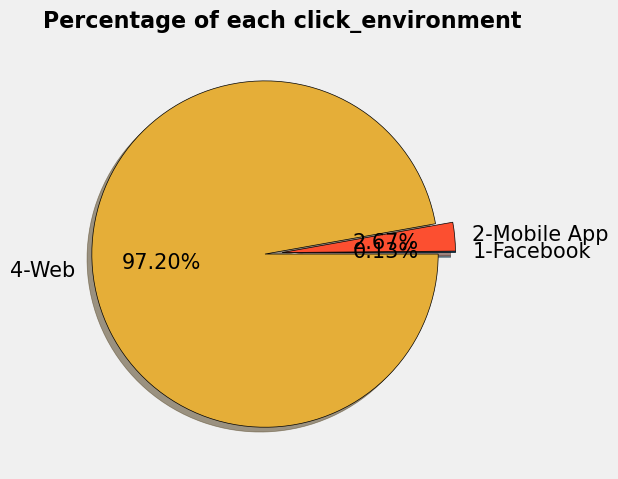

In [19]:
# Pie plot to display the percentage of each click_environment.
plt.figure(figsize=(6, 6))
labels=["1-Facebook", "2-Mobile App", "4-Web"]
slices = df_clicks.groupby("click_environment").size()
plt.pie(slices, 
        labels=labels, explode=[0, 0, 0.1], 
        shadow=True, startangle=0, autopct='%1.2f%%', 
        wedgeprops={'edgecolor': 'black'}, textprops={"fontsize":15})
plt.title("Percentage of each click_environment", 
          fontsize=16, 
          fontweight='bold')
plt.tight_layout()
plt.show()

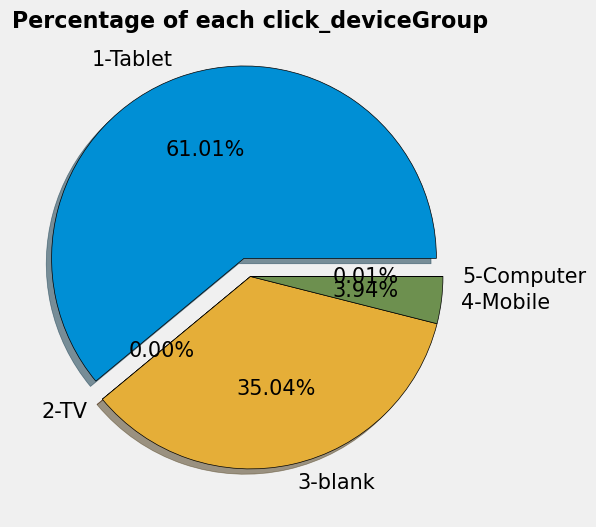

In [20]:
# Pie plot to display the percentage of each click_deviceGroup.
plt.figure(figsize=(6, 6))
labels=["1-Tablet", "2-TV", "3-blank", "4-Mobile", "5-Computer"]
slices = df_clicks.groupby("click_deviceGroup").size()
plt.pie(slices, 
        labels=labels, explode=[0.1, 0, 0, 0, 0], 
        shadow=True, startangle=0, autopct='%1.2f%%', 
        wedgeprops={'edgecolor': 'black'}, textprops={"fontsize":15})
plt.title("Percentage of each click_deviceGroup", 
          fontsize=16, 
          fontweight='bold')
plt.tight_layout()
plt.show()

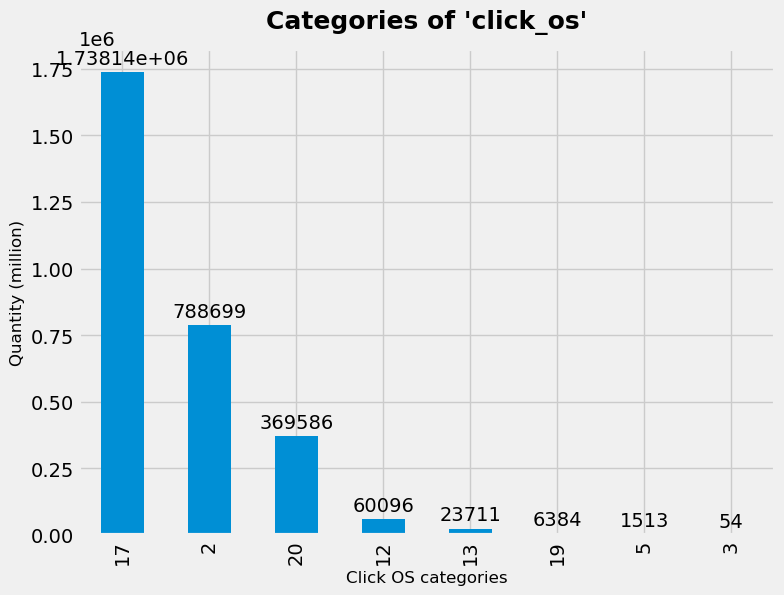

In [21]:
# Bar plot showing the different click_os categories and the respecting quantity.
ax = df_clicks['click_os'].value_counts().sort_values(ascending=False).plot.bar(
    figsize=(8, 6), fontsize=14)
plt.title("Categories of 'click_os'", 
          fontsize=18, pad=15, fontweight='bold')
plt.xlabel("Click OS categories", fontsize=12)
plt.ylabel("Quantity (million)", fontsize=12)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

### Note:  17 is ***'Firefox OS'***, 2 is ***'iOS'*** and 20 is ***'Chromecast'***

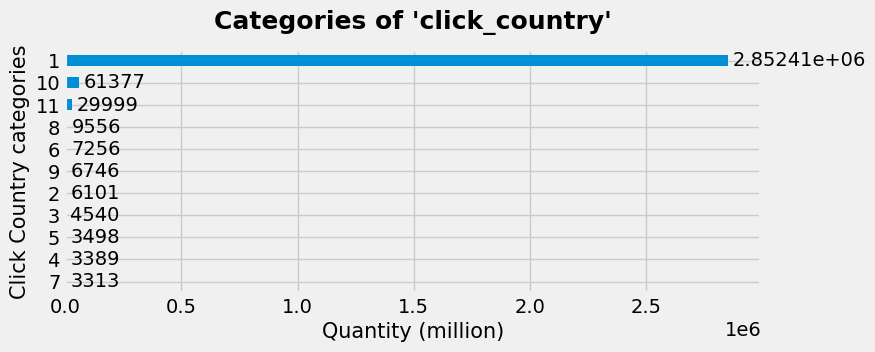

In [22]:
# Horizontal bar plot showing the different click_country and the respecting quantity.
ax = df_clicks['click_country'].value_counts().sort_values().plot.barh(
    figsize=(8, 3), fontsize=14)
plt.title("Categories of 'click_country'", 
          fontsize=18, pad=15, fontweight='bold')
plt.xlabel("Quantity (million)", fontsize=15)
plt.ylabel("Click Country categories", fontsize=15)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

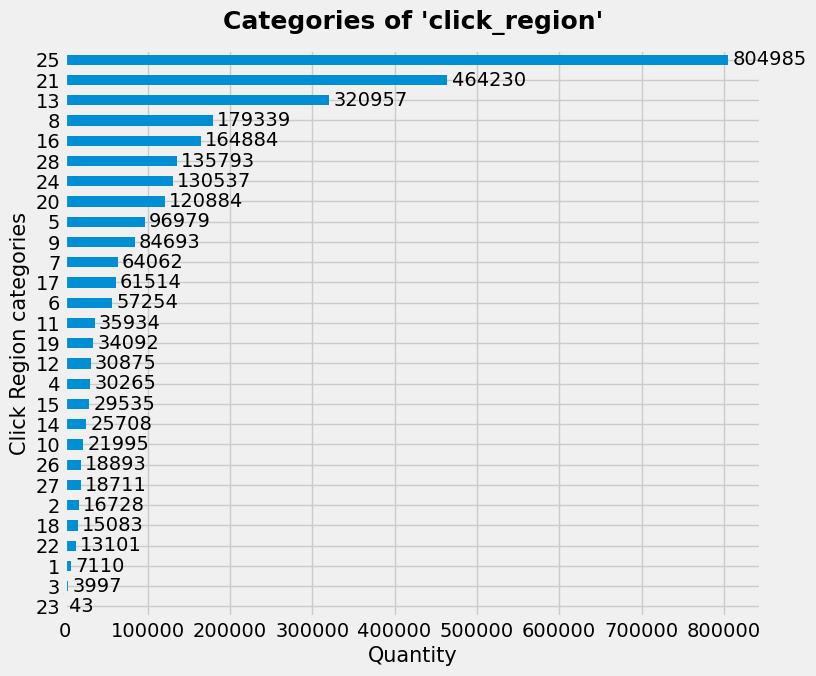

In [23]:
# Horizontal bar plot showing the different click_region and the respecting quantity.
ax = df_clicks['click_region'].value_counts().sort_values().plot.barh(
    figsize=(8, 7), fontsize=14)
plt.title("Categories of 'click_region'", 
          fontsize=18, pad=15, fontweight='bold')
plt.xlabel("Quantity", fontsize=15)
plt.ylabel("Click Region categories", fontsize=15)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

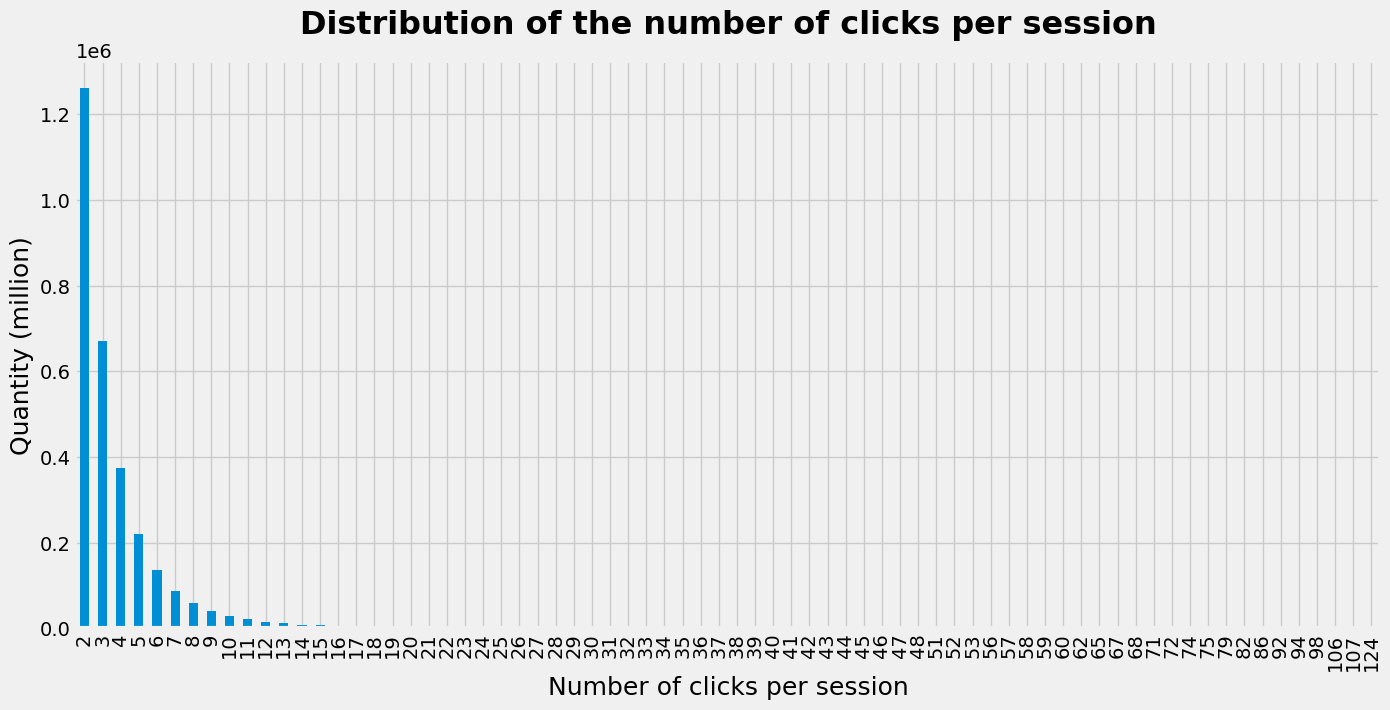

In [24]:
# Bar plot showing the distribution of the number of clicks per session.
df_clicks.groupby('session_size').size().plot(
    kind='bar', figsize=(15, 7))
plt.title("Distribution of the number of clicks per session", 
          fontsize=23, pad=20, fontweight='bold')
plt.xlabel("Number of clicks per session", fontsize=18)
plt.ylabel("Quantity (million)", fontsize=18)
ax.bar_label(ax.containers[0], padding=3, fontsize=16)
plt.show()

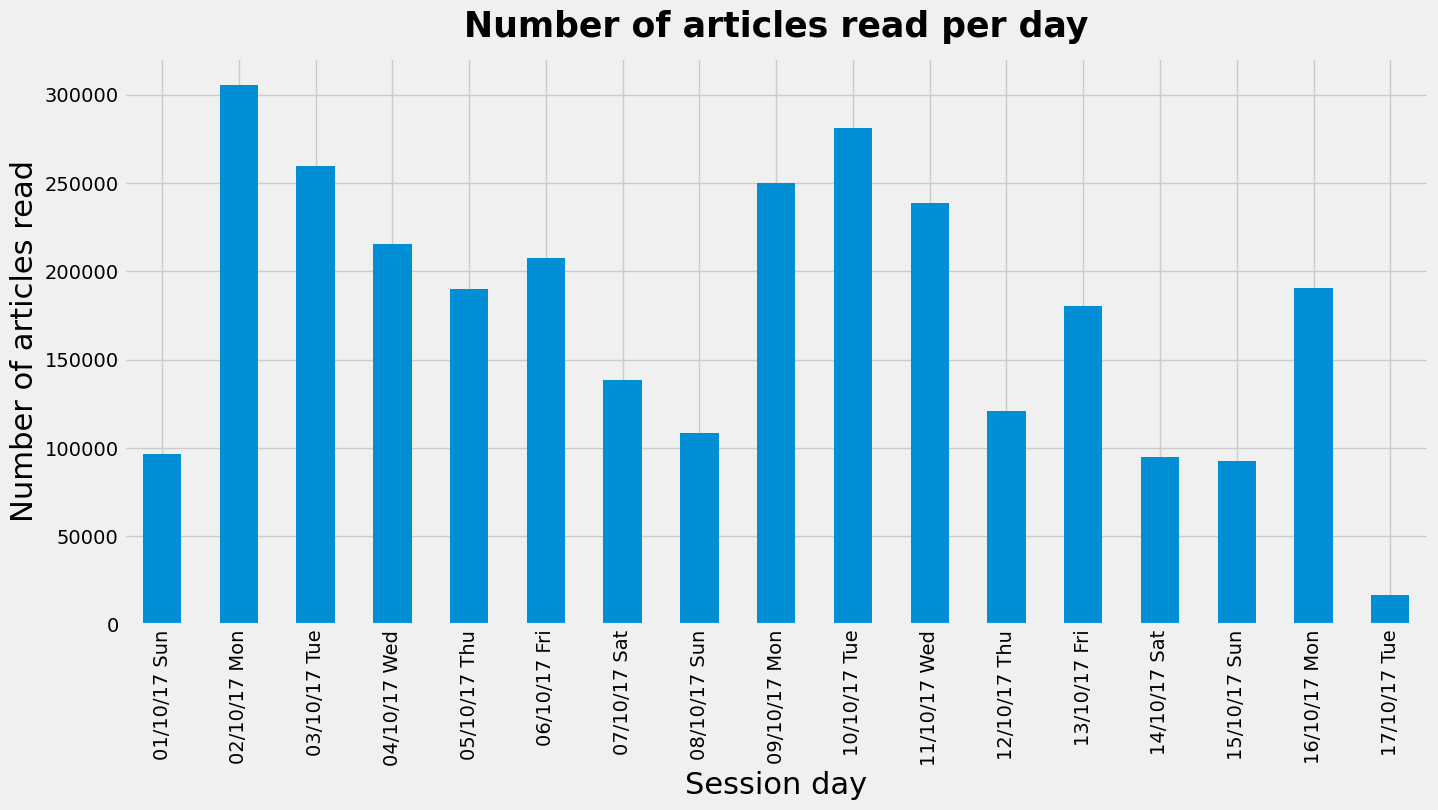

In [25]:
# Bar plot showing the Number of articles read per day.
df_clicks.groupby(df_clicks['session_start'].dt.strftime(
    '%d/%m/%y %a')).size().plot(kind='bar', figsize=(15, 7))
plt.title("Number of articles read per day", 
          fontsize=25, pad=15, fontweight='bold')
plt.xlabel("Session day", fontsize=22)
plt.ylabel("Number of articles read", fontsize=22)
plt.show()

In [26]:
# Timestamp of the interaction with the system.
min_int_date = df_clicks['click_timestamp'].min()
max_int_date = df_clicks['click_timestamp'].max()
print(f"\n\033[1mEarliest date of interaction: {min_int_date}")
print(f"\nMost recent date of interaction: {max_int_date}\033[0m")


Earliest date of interaction: 2017-10-01 03:00:00.026000

Most recent date of interaction: 2017-11-13 20:04:14.886000


Curious most recent date, as the interaction data ended on the 17th of October 2017!


Number of unique sessions per user: 
Mean: 16 | Median: 14 | Min: 4 | Max: 214



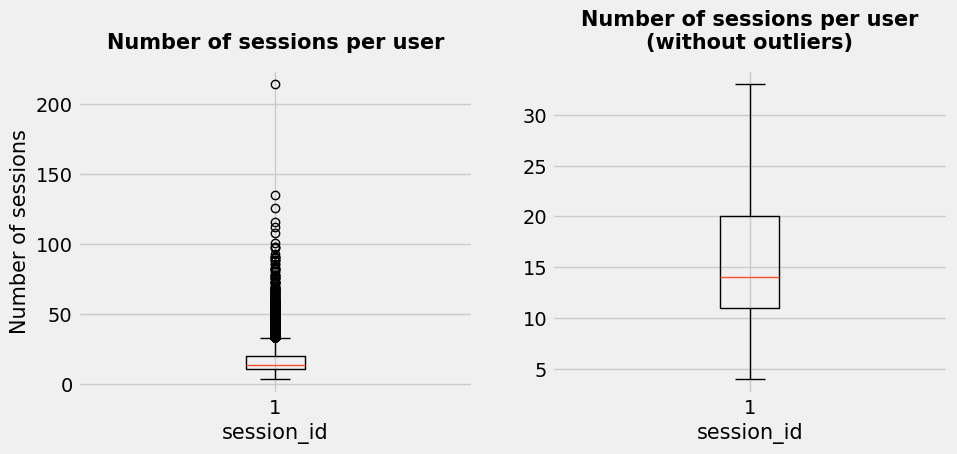

In [27]:
# Number of unique sessions per user.
x = df_clicks.groupby(['user_id'])['session_id'].nunique()
print(f'\n\033[1mNumber of unique sessions per user: \nMean: \
{round(x.mean())} | Median: {round(x.median())} | Min: {x.min()} \
| Max: {x.max()}\033[0m\n')

# Visualization of the number of sessions per user.
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(10, 4))

# Plotting boxplot of the number of sessions per user.
ax1.boxplot(x)
ax1.set_title('Number of sessions per user', 
              fontsize=15, fontweight='bold', pad=15)
ax1.set_xlabel('session_id', fontsize=15)
ax1.set_ylabel('Number of sessions', fontsize=15)

# Plotting boxplot of the number of sessions per user, without outliers.
ax2.boxplot(x, showfliers=False)
ax2.set_title('Number of sessions per user\n(without outliers)', 
              fontsize=15, fontweight='bold', pad=15)
ax2.set_xlabel('session_id', fontsize=15)

plt.show()


Number of read articles per user: 
Mean: 46 | Median: 38 | Min: 8 | Max: 1254



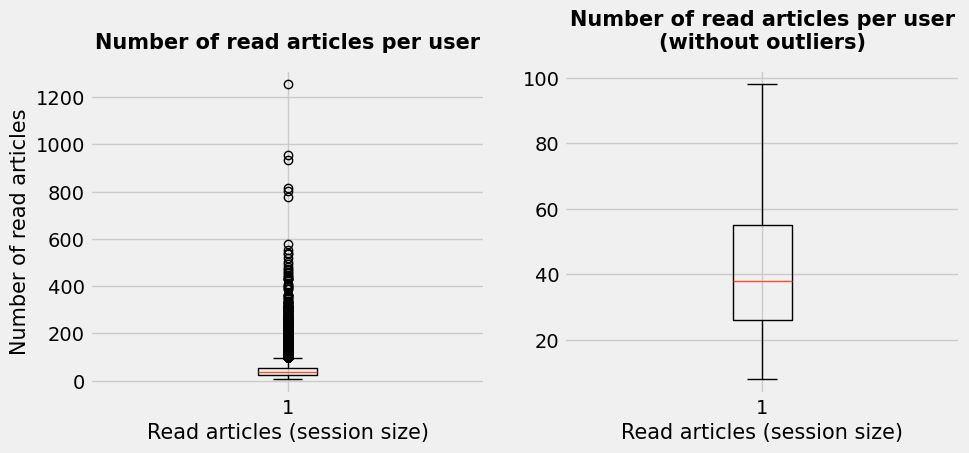

In [28]:
# Number of read articles per user during the period.
x = df_clicks.groupby(['user_id'])['session_size'].size()
print(f'\n\033[1mNumber of read articles per user: \nMean: \
{round(x.mean())} | Median: {round(x.median())} | Min: {x.min()} \
| Max: {x.max()}\033[0m\n')

# Visualization of the number of read articles per user.
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(10, 4))

# Plotting boxplot of the number of read articles per user.
ax1.boxplot(x)
ax1.set_title('Number of read articles per user', 
              fontsize=15, fontweight='bold', pad=15)
ax1.set_xlabel('Read articles (session size)', fontsize=15)
ax1.set_ylabel('Number of read articles', fontsize=15)

# Plotting boxplot of the number of read articles per user, without outliers.
ax2.boxplot(x, showfliers=False)
ax2.set_title('Number of read articles per user\n(without outliers)', 
              fontsize=15, fontweight='bold', pad=15)
ax2.set_xlabel('Read articles (session size)', fontsize=15)

plt.show()

### The essential part of the interaction between our 65 536 unique users and the news articles is via the globo.com web page, in majority using a tablet devise, mostly with Firefox OS, then iOS.

### Almost all users are from Brazil, from one of its 26 states or the federal district (regions here).

### During a typical session, the user would read 2 or 3 different articles, mostly at the beginning of the week.

### In total, we had 2 988 181 clicks during 16 days, between the 1st to the 17th of October 2017.

### Finally, each user, during the period, had between 4 to 214 sessions, with a median of 14.<br>They each read between 8 to 1254 news articles, with a median of 38.

## • df_articles

### Let's dive now into the articles.

In [29]:
# First, let's see if we have articles without words_count.
no_words_count = df_articles[df_articles['words_count'] == 0].nunique()[0]
print(f"\033[1mNumber of articles with 'words_count'=0: \
{no_words_count}\033[0m")

Number of articles with 'words_count'=0: 35


We decide to do nothing about it.

In [30]:
# Period of creation of the articles.
min_date = df_articles['created_at_ts'].min()
max_date = df_articles['created_at_ts'].max()
print(f"\n\033[1mEarliest creation date for the articles: {min_date}")
print(f"\nMost recent creation date for the articles: {max_date}\033[0m")


Earliest creation date for the articles: 2006-09-27 11:14:35

Most recent creation date for the articles: 2018-03-13 12:12:30


Curious most recent date, as the interaction data ended on the 17th of October 2017!

In [31]:
# Minimum, maximum and mean number of words in the news articles.
min_words = df_articles['words_count'].min()
max_words = df_articles['words_count'].max()
mean_words = df_articles['words_count'].mean()
print(f"\033[1m\nThe articles contain between {min_words} \
and {max_words} words, with a mean of {round(mean_words)} words.\033[0m")


The articles contain between 0 and 6690 words, with a mean of 191 words.


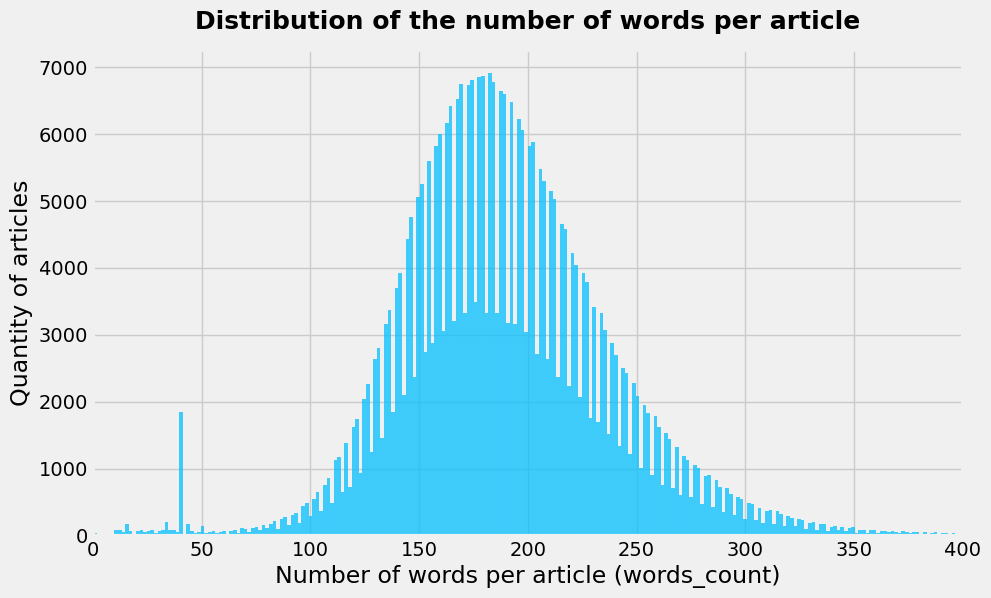

In [32]:
# Distribution of the number of words per article.
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df_articles['words_count'], color="deepskyblue")

plt.xlim([0, 400])  # limiting to a maximum 400 words per article.
plt.title("Distribution of the number of words per article", 
          fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Number of words per article (words_count)", fontsize=17)
plt.ylabel("Quantity of articles", fontsize=17)
plt.show()

## • Merging the 2 dataframes

### Let's merge df_clicks and df_articles on the base of the article_id.

In [33]:
# Renaming one column.
df_clicks.rename(columns={'click_article_id':'article_id'}, inplace=True)

# Joining df_clicks and df_articles on the 'article_id' column. 
df_merged = df_clicks.merge(df_articles, on='article_id', how='left')

# Displaying the shape and a sample of 5 rows.
print(f"\n\033[1mdf_merged shape:\033[0m {df_merged.shape}\n")
df_merged.sample(5)


df_merged shape: (2988181, 16)



,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,...,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count
1422498,30094,1507427544343495,2017-10-08 01:52:24,7,175279,2017-10-08 02:14:49.066,4,...,1,4,1,299,2017-10-06 23:25:56,0,153
187060,58867,1506948986744563,2017-10-02 12:56:26,2,160974,2017-10-02 12:58:40.767,4,...,1,13,1,281,2017-10-02 02:52:27,0,259
2309245,40279,1507775714208545,2017-10-12 02:35:14,2,111043,2017-10-12 02:36:22.616,4,...,1,20,2,231,2017-10-11 14:40:18,0,195
2107211,10968,1507719554184234,2017-10-11 10:59:14,2,202330,2017-10-11 11:12:08.840,4,...,1,21,1,327,2017-10-10 18:52:47,0,150
1938238,302,1507648667186675,2017-10-10 15:17:47,5,234698,2017-10-10 15:29:43.089,4,...,1,21,2,375,2017-10-10 06:56:37,0,183


<function matplotlib.pyplot.show(close=None, block=None)>

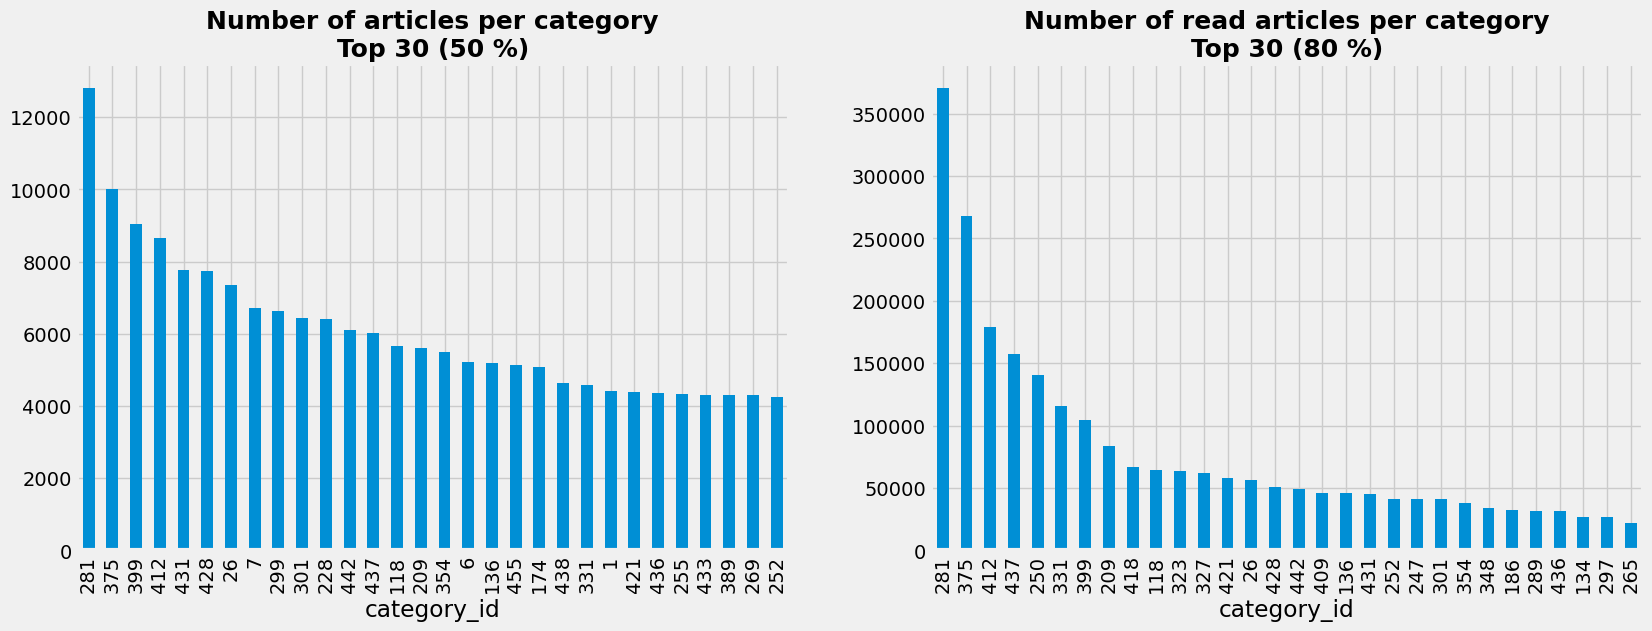

In [34]:
# Grouping articles by category.
# Number of articles per category.
art_cat = df_articles.groupby(
    'category_id')['article_id'].nunique().sort_values(ascending=False)
# Number of read articles per category.
read_art_cat = df_merged.groupby(
    'category_id')['article_id'].count().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plotting the number of articles per category for the top 30.
art_cat.head(30).plot(kind='bar', ax=ax1)
perc1 = round(sum(art_cat.head(30))/sum(art_cat) * 100)
ax1.set_title(
    f'Number of articles per category\nTop 30 ({perc1} %)', 
    fontsize=18, fontweight='bold')

# Plotting the number of articles per category for the top 30.
read_art_cat.head(30).plot(kind='bar', ax=ax2)
perc2 = round(sum(read_art_cat.head(30))/sum(read_art_cat) * 100)
ax2.set_title(
    f'Number of read articles per category\nTop 30 ({perc2} %)',
    fontsize=18, fontweight='bold')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

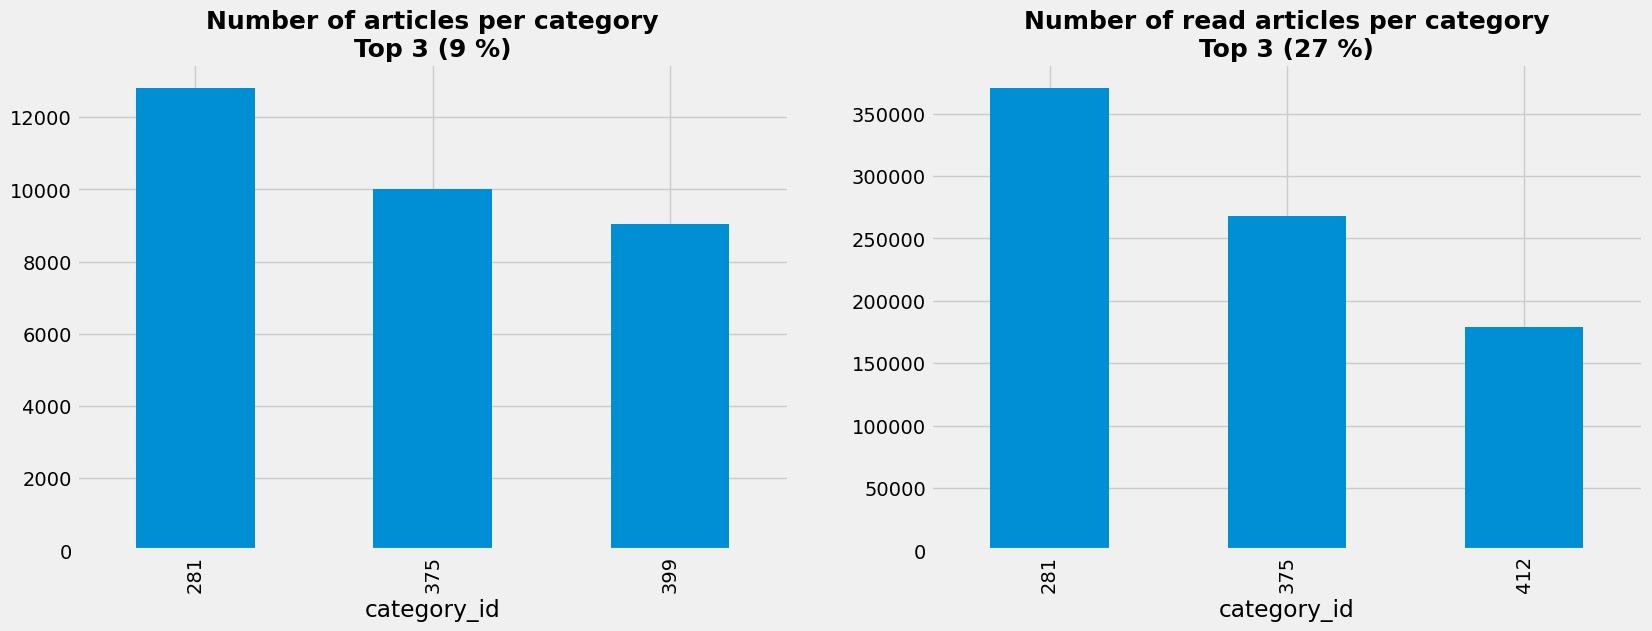

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plotting the number of articles per category for the top 3.
art_cat.head(3).plot(kind='bar', ax=ax1)
perc1 = round(sum(art_cat.head(3))/sum(art_cat) * 100)
ax1.set_title(
    f'Number of articles per category\nTop 3 ({perc1} %)', 
    fontsize=18, fontweight='bold')

# Plotting the number of articles per category for the top 3.
read_art_cat.head(3).plot(kind='bar', ax=ax2)
perc2 = round(sum(read_art_cat.head(3))/sum(read_art_cat) * 100)
ax2.set_title(
    f'Number of read articles per category\nTop 3 ({perc2} %)',
    fontsize=18, fontweight='bold')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

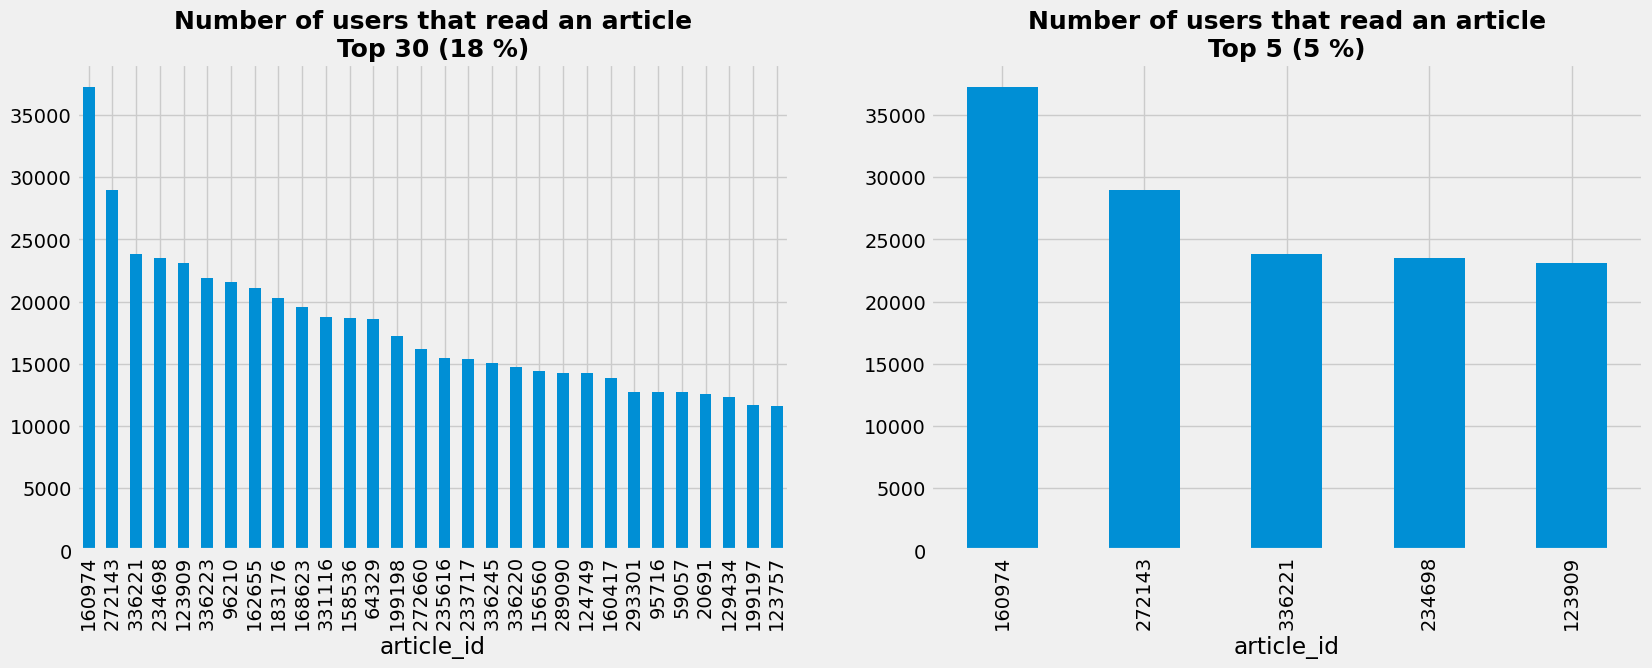

In [36]:
# Number of users that read an article.
read_art_user = df_merged.groupby(
    'article_id')['user_id'].count().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plotting the number of users that read an article for the top 30.
read_art_user.head(30).plot(kind='bar', ax=ax1)
perc3 = round(sum(read_art_user.head(30))/sum(read_art_user) * 100)
ax1.set_title(
    f'Number of users that read an article\nTop 30 ({perc3} %)', 
    fontsize=18, fontweight='bold')

# Plotting the number of users that read an article for the top 5.
read_art_user.head(5).plot(kind='bar', ax=ax2)
perc4 = round(sum(read_art_user.head(5))/sum(read_art_user) * 100)
ax2.set_title(
    f'Number of users that read an article\nTop 5 ({perc4} %)',
    fontsize=18, fontweight='bold')

plt.show

### During the period of time (16 days), 46 033 of these news articles have been read in a total of 364 047 news articles, in 461 different categories.

### The articles contain up to 6 690 words, with a mean of 191 words, with a quite gaussian distribution.

### The top 30 categories gather 50 % of all published articles, and 80 % of all read articles.

### The most read articles belong to the categories 281, 375 and 412 and represent 27 % of all read articles.

### The 30 most read articles has been read by 18 % of the users, 5 % for the top 5 articles.

<h2><div class="alert alert-block alert-success" id="section_1">
PART 1 - DATA PREPARATION</div></h2>

After exploring the data, in our case, we found that <b>we don't have explicit data from the users</b>; articles rating for example.<br>
<b>We will work on implicit data, e.g. users' interactions with the system.</b>

As the concentration on some categories for the read articles is important, we could have an important biais on the popular articles if we use the category_id column. So we won't.

With our data, we <b>will build (the implicit) rating</b>, and thus prepare the data for <b>Colaborative Filtering</b>. How so, we will see it later on.

For <b>Content-Based Filtering</b>, we will use the <b>article embeddings file</b> we have. Let's see more about it, right now. 

<h3><div class="alert alert-block alert-info" id="section_1A">
A - FINAL DATASET FOR CONTENT-BASED FILTERING</div></h3>

<h4><div class="alert alert-block alert-warning" id="section_1A1">
1 - Article embeddings</div></h4>

In [37]:
# Loading the article embeddings with pickle.
with open("datasets/articles_embeddings.pickle", "rb") as file:
    embeddings = pickle.load(file)

In [38]:
# Saving the article embeddings as a dataframe.
df_embed = pd.DataFrame(embeddings)
df_embed = df_embed.add_prefix('dim_')
df_embed

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,...,dim_243,dim_244,dim_245,dim_246,dim_247,dim_248,dim_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,...,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,...,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,...,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,...,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,...,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,-0.055038,-0.962136,0.869436,-0.071523,-0.725294,0.434320,0.198312,...,0.167907,-0.480068,0.652090,0.380880,0.433195,-0.662455,-0.222850
364043,-0.136932,-0.995471,0.991298,0.031871,-0.915622,-0.658517,0.633090,...,0.688934,0.528204,0.162435,0.940364,0.989298,-0.761595,-0.414652
364044,-0.251390,-0.976243,0.586097,0.643631,-0.663359,-0.093480,0.691553,...,0.352132,-0.311279,0.460574,-0.653077,-0.143725,0.068093,-0.705010
364045,0.224342,-0.923288,-0.381742,0.687890,-0.773911,-0.103629,-0.406486,...,-0.646753,-0.174031,0.698037,-0.317102,0.687132,-0.531512,0.010726


**This article embeddings matrix shows for each article a vector of dimension 250.**

<h4><div class="alert alert-block alert-warning" id="section_1A2">
2 - Final dataset</div></h4>

In [39]:
# Cleaning the final dataset of useless columns.
df_merged_cb = df_merged[['user_id', 'article_id']]
df_merged_cb

,user_id,article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592
...,...,...
2988176,10051,84911
2988177,60752,30760
2988178,60752,157507
2988179,58182,234481


<h3><div class="alert alert-block alert-info" id="section_1B">
B - FINAL DATASET FOR COLLABORATIVE FILTERING</div></h3>

<h4><div class="alert alert-block alert-warning" id="section_1B1">
1 - Creating the rating</div></h4>

### Rating per user = Total clicks per category / Total clicks ???

Surprise is an easy-to-use Python scikit for recommender systems.<br>
Surprise was designed for explicit ratings. We can't use it for content-based data or implicit ratings. So we need to build our own ratings.

<h4><div class="alert alert-block alert-warning" id="section_1B2">
2 - Final dataset</div></h4>

In [40]:
# Cleaning the final dataset of useless columns.
df_merged_cf = df_merged[['user_id', 'session_id', 
                          'session_size', 'article_id', 
                          'category_id', 'words_count']]
df_merged_cf

,user_id,session_id,session_size,article_id,category_id,words_count
0,0,1506825423271737,2,157541,281,280
1,0,1506825423271737,2,68866,136,226
2,1,1506825426267738,2,235840,375,159
3,1,1506825426267738,2,96663,209,206
4,2,1506825435299739,2,119592,247,239
...,...,...,...,...,...,...
2988176,10051,1508211372158328,2,84911,174,171
2988177,60752,1508211376302329,2,30760,26,162
2988178,60752,1508211376302329,2,157507,281,370
2988179,58182,1508211379189330,2,234481,375,212


<h3><div class="alert alert-block alert-info" id="section_1C">
C - PERFORMANCE AND DISTANCE METRICS</div></h3>

### References:

<img src="images/references.png" width="400" height="400">

In [41]:
# To get the same results when training and testing the models.
random.seed(52)
np.random.seed(52)

We will use the 3 similar performance metrics that evaluate the error - that is, the average squared difference between the estimated values and the actual value. 

The goal is to find the models that minimize these metrics.

<h4><div class="alert alert-block alert-warning" id="section_1C1">
1 - Performance metrics</div></h4>

### Root Mean Squared Error:

<img src="images/rmse.png" width="250" height="250">

### Mean Squared Error:

<img src="images/mse.png" width="250" height="250">

### Mean Absolute Error:

<img src="images/mae.png" width="250" height="250">

<h4><div class="alert alert-block alert-warning" id="section_1C2">
2 - Distance metrics</div></h4>

### Cosine similarity for users:

<img src="images/cosine_user.png" width="400" height="400">

### Cosine similarity for articles:

<img src="images/cosine_item.png" width="400" height="400">

<h2><div class="alert alert-block alert-success" id="section_2">
PART 2 - CONTENT-BASED METHODS</div></h2>

<h3><div class="alert alert-block alert-info" id="section_2A">
A - PRESENTATION OF THIS APPROACH</div></h3>

Content-Based recommenders rely on attributes of users and/or items, here news articles from globo.com.<br>
In our case, we don't have specific information about the users, but we have content data about the articles with the content embeddings (vectors of dimension 250), trained upon these articles's text and metadata. Maybe we can include the word counts, as the lenght of an article might influence reading.<br>
Here, we don't need information about other users, unlike collaborative filtering, and so, it's easier to scale.<br>
The drawback is over-specialization: if a user is only interested in specific categories, recommender will have difficulty recommending items outside of this scope. These do not take users' behavioral information into account and discount the fact that user interest and preferences may change over time.

<h3><div class="alert alert-block alert-info" id="section_2B">
B - DEFINING SIMILARITY</div></h3>

Our first content-based recommender will have a goal of recommending news articles which have similar text and metadata. We will then use the embeddings file.

On aura pu recommander les memes categories deja lu et parmi elles les articles les plus populaires

• La démarche consiste à réaliser un calcul de similarité cosine des « embeddings » entre un article de l’utilisateur et l’ensemble des autres articles, et de prendre les 5 articles les plus proches. Dans la plupart des cas l’utilisateur a cliqué sur plusieurs articles, il y a donc plusieurs stratégies possibles pour choisir l’article ; je vais prendre celle-ci : faire une moyenne des embeddings des articles lus, pondérés ou non par le nombre de clics sur chaque article.<br>
• Pour le MVP, le calcul de similarité pourra se faire à la demande, pour l’utilisateur concerné.

Content-based systems exploit user and item atributes/features to recommend items that match user profiles. These do not depend on user feedback or ratings.

The idea here is to recommend to a user 5 articles similar to the ones already read by the same user.<br>
For that, we will use the article embeddings file and search the closest cosine similarity scores and recommend the first 5 ones.

In [42]:
# with open('cosine_similarity_matrix.npy', 'wb') as file:
#     np.save(file, cosine_similarity_matrix)

In [43]:
def MeanEmbeddings(artList):
    """Function to calculate the mean embeddings with a list of article ids.
    """
    # Selecting the only embeddings of the articles list.
    df = df_embed.iloc[artList, :]
    # Calculating the mean embeddings, the syntesis of all articles.
    mean_emb = df.mean()
    # Transpose the result into a dataframe with one row (article) 
    # and 250 columns (embedding vector).
    mean_emb = mean_emb.to_frame().transpose()
    return mean_emb

In [44]:
def CBRecommender(userId, topN=5):
    """Function to return the top-N article recommendation for an user id,
    using a Content-Based filtering Recommender System.
    The returned (by default 5 articles ids) list is sorted by confidence descending.
    """
    # Creating a list (article ids) with the read articles by the user.
    user_art_list = df_merged_cb.loc[
        df_merged_cb['user_id'] == userId]['article_id'].to_list()
    
    # Calculating the mean of these read articles embeddings,
    # weighted by the number of clicks on each article, creating a 'synthetic article'.
    mean_emb = MeanEmbeddings(user_art_list)
    
    # Calculating cosine similarity between the 'synthetic article' and
    # all the other articles, with the embeddings vectors.
    cosine_sim = cosine_similarity(df_embed, mean_emb)
    df_cosine_sim = pd.DataFrame(cosine_sim, columns=['cosine_sim'])
    
    # ATTENTION LES ARTICLES DOIVENT ETRE DIFFERENTS DE CEUX DE LA LISTE LUE
    # Selecting the N closest articles.
    topN_articles = df_cosine_sim.sort_values(
        by='cosine_sim', ascending=False, inplace=False).head(topN)
    topN_articles_list = topN_articles.index.tolist()
    
    return topN_articles_list, user_art_list, df_cosine_sim, topN_articles

<h3><div class="alert alert-block alert-info" id="section_2C">
C - RECOMMENDATION</div></h3>

In [45]:
%%time
reco0, user_art_list0, df_cosine_sim0, topN_articles0 = CBRecommender(0)
print(reco0)
print(sorted(user_art_list0))
df_cosine_sim0.iloc[user_art_list0]

[280420, 284371, 282763, 284797, 284721]
[32750, 57616, 58565, 59758, 64329, 68866, 87192, 87205, 87224, 95972, 96210, 96755, 108856, 119193, 123290, 123757, 123909, 123909, 124194, 124352, 124749, 129029, 141004, 146077, 156625, 157541, 160158, 160974, 169175, 199197, 207797, 214393, 218028, 225124, 233470, 235870, 236338, 276970, 277712, 282964, 283238, 284090, 284339, 285379, 286128, 286350, 289003, 289003, 299152, 299841, 313996, 336223, 336254, 336476, 337435, 348113, 353672]
CPU times: user 354 ms, sys: 283 ms, total: 636 ms
Wall time: 241 ms


,cosine_sim
157541,0.535468
68866,0.608364
160974,0.490845
59758,0.586509
336476,0.666262
64329,0.519582
129029,0.538385
199197,0.419253
337435,0.599820
32750,0.410481


In [46]:
topN_articles0

,cosine_sim
280420,0.806651
284371,0.805882
282763,0.802847
284797,0.797573
284721,0.793950


In [47]:
reco1, user_art_list1, df_cosine_sim1, topN_articles1 = CBRecommender(34890, 8)
print(reco1)
print(sorted(user_art_list1))
df_cosine_sim1.iloc[user_art_list1]

[345218, 312430, 233480, 353599, 160940, 160871, 157297, 160894]
[20691, 39894, 42158, 42430, 48121, 48321, 48796, 64329, 71161, 83622, 83738, 111043, 157478, 160748, 162655, 168377, 168416, 168743, 168784, 183176, 209653, 233688, 251786, 277107, 283009, 289003, 293301, 303331, 313602, 337441, 363916]


,cosine_sim
83738,0.417168
83622,0.501476
162655,0.538701
64329,0.578765
293301,0.580645
313602,0.459641
303331,0.472195
209653,0.608153
20691,0.501273
337441,0.500333


In [48]:
topN_articles1

,cosine_sim
345218,0.777475
312430,0.755987
233480,0.755214
353599,0.752475
160940,0.750665
160871,0.749502
157297,0.749420
160894,0.748994


In [49]:
dcvvcvcc0.748994

SyntaxError: invalid syntax (2914475336.py, line 1)

<h2><div class="alert alert-block alert-success" id="section_3">
PART 3 - COLLABORATIVE FILTERING METHODS</div></h2>

Collaborative Filtering uses information on the interaction between users and items, here articles, expressed in the user-item interaction matrix.

No explicit data here, no rating for the read articles from the users. So, we don't know if the users licked or not those read articles.<br>
We have no consistent metrics about the users' interest on the read articles.

surprise Trainset() plein de méthodes

**Élaboration d’un modèle de type Collaborative Filtering**<br>
Il n’y a pas de Rating explicite (comme par exemple une note d’appréciation des articles par les utilisateurs) ; il est donc nécessaire de déterminer un Rating implicite, par exemple le nombre de clics pour un utilisateur sur un article. Ce nombre peut être pondéré, selon l’activité de l’utilisateur, par exemple par son nombre total de clics ou le nombre de clics sur sa session (session_size).

<h3><div class="alert alert-block alert-info" id="section_3A">
A - PRESENTATION OF THIS APPROACH</div></h3>

Collaborative filtering based systems collect & analyze users’ behavioral information in the form of their feedback, ratings, preferences and activities. Based on this information, these then exploit similarities amongst several users/ items to predict missing ratings and hence make suitable recommendations. Collaborative filtering systems can discover and learn features on its own without the need of explicit features to profile items or users.

#### • Memory-based/Neighborhood-based

- User-based: The key notion here is to determine users, who are like the target user A, and recommend ratings for the unobserved ratings of A by calculating weighted averages of the ratings of this peer group. User-based approach finds n users who have rated the movies similar to user A. Similarity measure like Cosine similarity, Pearson similarity are used, and a weighted average of ratings of k most similar users is taken. En gros, on cherche des users qui ont les mêmes goûts e films que le user et on note le film comme eux l'ont noté. 

- Item-based: Item-based approach finds n movies which have been rated similar to The Hobbit by other users. To predict the rating that user A will give to The Hobbit, a weighted average of ratings of k most similar movies is taken. En gros le rating donné par les autres users sur n autres films a été le meme que celui cherché, donc il faut noter le film de la meme façon que le user a noté ces autres films.

#### • Model-based/Matrix Factorization

Model-based Collaborative Filtering approach employs dimensionality reduction techniques like matrix factorization (Singular Value Decomposition — SVD, Principal Component Analysis- PCA and Latent Factor models) to discover hidden concepts and their relationship with users and items.<br>
Matrix factorization allows User-Item rating matrix to be decomposed into smaller user-concept matrix and item-concept matrix, where each user and item is represented by f-dimensional vectors. Elements of user vector measure the extent of interest user has in each of the f concepts (features/factors). Elements of item vector measure the extent of strength of each of the concepts against that item. The dot product of user and item vectors i∙u = i’u is used to estimate user’s interest in a specific item.<br>
Referring to the movie recommendation example above, user-movie rating matrix can be represented by lower dimensional user-concept and movie-concept matrix where romance and action could be the latent concepts (not known in advance) or features defining the user-movie interactions. Choice of f is a trade-off between discovering hidden concepts and avoiding overfitting, therefore, f should be chosen wisely.<br><br>
For large number of users and items, collaborative filtering approaches however suffer from sparsity problems (as many of the items are not rated by users) and hence accuracy of the system falls-off. However, model-based CF systems are more scalable as compared to memory-based systems and are more robust to deal with sparsity issues.<br>
Unlike CB recommender systems, CF recommender systems are more versatile and do not require feature modeling specific to domain.

##########################

On va faire les 2 approches avec la seule approche user-based filtering, pas item-based filtering car.......

Approche 1 de Centered k-NN avec KNNWithMeans de surprise

Approche 2 de Matrix Factorization avec SVD de surprise

<h3><div class="alert alert-block alert-info" id="section_3B">
B - DEFINING SIMILARITY</div></h3>

### How to get the top-n recommendations for each user ---> code dans doc surprise

In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

### How to get the k nearest neighbors of a user (or item) ---> code dans doc surprise

In [ ]:
def read_item_names():
    """Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    """

    file_name = get_dataset_dir() + "/ml-100k/ml-100k/u.item"
    rid_to_name = {}
    name_to_rid = {}
    with open(file_name, encoding="ISO-8859-1") as f:
        for line in f:
            line = line.split("|")
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid

In [ ]:
# First, train the algorithm to compute the similarities between items
sim_options = {"name": "pearson_baseline", "user_based": False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

# Read the mappings raw id <-> movie name
rid_to_name, name_to_rid = read_item_names()

# Retrieve inner id of the movie Toy Story
toy_story_raw_id = name_to_rid["Toy Story (1995)"]
toy_story_inner_id = algo.trainset.to_inner_iid(toy_story_raw_id)

# Retrieve inner ids of the nearest neighbors of Toy Story.
toy_story_neighbors = algo.get_neighbors(toy_story_inner_id, k=10)

# Convert inner ids of the neighbors into names.
toy_story_neighbors = (
    algo.trainset.to_raw_iid(inner_id) for inner_id in toy_story_neighbors
)
toy_story_neighbors = (rid_to_name[rid] for rid in toy_story_neighbors)

print("The 10 nearest neighbors of Toy Story are:")
for movie in toy_story_neighbors:
    print(movie)

### KNNWithMeans() sera la baseline puis SVD() (puis SVDpp() ?)

#####################  REAL PYTHON

In [ ]:
# Parsing a file containing ratings. 
# only one rating per line, and each line needs to respect the following structure:
# user ; item ; rating
reader = Reader(rating_scale=(1, 5))  # why 1, 5 ???
# Reader(name=None, line_format='user item rating', sep=None, rating_scale=(1, 5), skip_lines=0)
# where the order of the fields and the separator (here ‘;’) may be arbitrarily defined.
# name (string, optional) – If specified, a Reader for one of the built-in datasets. Default is None.
# line_format (string) – The fields names, in the order at which they are encountered on a line. 
# Please note that line_format is always space-separated (use the sep parameter). Default is 'user item rating'.
# sep (char) – the separator between fields. Example : ';'.
# rating_scale (tuple, optional) – The rating scale used for every rating. Default is (1, 5).
# skip_lines (int, optional) – Number of lines to skip at the beginning of the file. Default is 0.

# Loads Pandas dataframe. Each lines must respect the following structure : user; item; rating.
data = Dataset.load_from_df(df[["user_id", "article_id", "rating"]], reader)

In [ ]:
# To use item-based cosine similarity
# KNNWithMeans: A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
sim_options = {
    "name": "cosine", 
    "user_based": False,  # Compute  similarities between items 
}
algo = KNNWithMeans(sim_options=sim_options)

In [ ]:
algo.fit(trainset)

In [ ]:
prediction = algo.predict('E', 2)
prediction.est

The GridSearchCV class computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. This is useful for finding the best set of parameters for a prediction algorithm. It is analogous to GridSearchCV from scikit-learn.

In [ ]:
sim_options = {
    "name": ["msd", "cosine"], 
    "user_based": [False, True],
    "min_support": [3, 4, 5],  # why ? the minimum number of common items needed between users to consider them for similarity
}
# msd: Compute the Mean Squared Difference similarity between all pairs of users (or items)
# cosine: Compute the cosine similarity between all pairs of users (or items).

param_grid = {
#     "k": [30, 40, 50],
#     "min_k": [1, 2, 3], 
    "sim_options": sim_options
}

gs = GridSearchCV(KNNWithMeans, 
                  param_grid, 
                  measures=["rmse", "mae"],
                  n_jobs=-1,  # all CPUs are used.
                  cv=5)
gs.fit(data)

print(gs.best_score["rmse"])  # Root Mean Squared Error
print(gs.best_params["rmse"])
print(gs.best_score["mse"])  # Mean Squared Error
print(gs.best_params["mse"])
print(gs.best_score["mae"])  # Mean Absolute Error
print(gs.best_params["mae"])

In [ ]:
# The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. 
param_grid = {
    "n_epochs": [5, 10],  # The number of iteration of the SGD procedure. Default is 20.
    "lr_all": [0.002, 0.005],  # The learning rate for all parameters. Default is 0.005.
    "reg_all": [0.4, 0.6],  # The regularization term for all parameters. Default is 0.02.
}
gs = GridSearchCV(SVD(random_state=52), 
                  param_grid, 
                  measures=["rmse", "mae"], 
                  cv=5)

gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])
print(gs.best_score["mse"])
print(gs.best_params["mse"])
print(gs.best_score["mae"])
print(gs.best_params["mae"])

In [ ]:
#####################################

In [ ]:
clicks_articles2 = clicks_articles[['user_id', 'article_id', 'category_id']]
clicks_articles2

In [ ]:
%%time
series = clicks_articles2.groupby(['user_id', 'category_id']).size()
user_rating_matrix = series.to_frame()
user_rating_matrix = user_rating_matrix.reset_index()
user_rating_matrix.rename(columns={0: 'rate'}, inplace=True)

In [ ]:
user_rating_matrix

1882302 rows × 3 columns

<h3><div class="alert alert-block alert-info" id="section_3C">
C - RECOMMENDATION</div></h3>

In [ ]:
# As we're loading a custom dataset, we need to define a reader.
reader = Reader()  # rating_scale=(1, 10)

In [ ]:
_x = user_rating_matrix.loc[user_rating_matrix.rate > 1]
data = Dataset.load_from_df(
    _x[['user_id', 'category_id', 'rate']], reader)
print(f"We have selected {len(_x)} interections.")

In [ ]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(
    data, test_size=0.25, random_state=52)

In [ ]:
# We'll use the famous Singular Vector Decomposition (SVD) algorithm.
algo = SVD()
# Train the algorithm on the trainset, and predict ratings for the testset.
algo.fit(trainset)
predictions = algo.test(testset)

In [ ]:
# Then compute RMSE.
accuracy.rmse(predictions)

We have selects 503616 interactions.

7.413344626148932

## Dump and load the model

In [ ]:
# Dumping the chosen model.
file_name = os.path.expanduser("~/dump_file")
dump.dump(file_name=file_name, algo=algo, verbose=1)

In [ ]:
# Reloading the chosen model (returns a tuple (predictions, algo)).
_, load_algo = dump.load(file_name=file_name)

In [ ]:
# Is the algo still the same ? Sanity check.
predictions_loaded_algo = load_algo.test(testset)
assert predictions == predictions_loaded_algo
print("Predictions are the same.")

Hyperparameter tuning with cross-validation with surprise.

<h2><div class="alert alert-block alert-success" id="section_00">
CONCLUSION</div></h2>

### • Hybrid Methods

Memory-based and model-based collaborative filtering approaches can be combined in practice to exploit the benefits each of the approaches provide. Also, content-based and collaborative filtering approaches can be combined in various ways to achieve greater synergies between them.

Hybrid methods can minimize the drawbacks of any of the individual methods, and are for that the way to follow for further investigation.

A recommendation system should be built on the fact that the people's taste can change over time. So, the recommendation system should be better over time, as more data come and it learns from it. 

<img src="images/my_content.png" width="250" height="250">

Dans la deuxième architecture, tu peux te passer de l’API, en exploitant les fonctionnalités “Azure Blob storage input binding” pour récupérer directement les fichiers et modèles, et en intégrant tes prédictions directement dans ton Azure Functions

Il est conseillé de créer votre Azure Function directement sur le portail Azure, et de choisir le “plan type” égal à “Consomption(serverless)”, afin d’utiliser l’option gratuite de Service Plan

Sélectionner l’architecture logicielle permettant de répondre au besoin métier :<br> 
    • les différentes briques d’architecture nécessaires pour la réalisation de la solution répondant au besoin métier ont été identifiées.<br>
    • la description fonctionnelle de chaque brique d’architecture a été réalisée.<br>
    • les besoins de mise à jour des bases de données Utilisateurs et Articles ont été pris en compte dans la description fonctionnelle.<br>
    • une explication sous forme de schéma des différentes briques de l’architecture logicielle a été élaborée.<br>
    

### Django Application

Pour l’application, tu peux créer en local une simple interface qui liste les id des users et affiche les résultats des 5 suggestions d’articles, suite à appel de l’Azure Functions.

 fichier “embeddings” : tu peux réaliser une réduction de dimension de ce fichier via une ACP.

une architecture serverless avec Azure Functions 